<a href="https://colab.research.google.com/github/DCI-alxogm/ml2023-BlackPuma075/blob/main/Oct6_7/Tarea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
file = '/content/drive/MyDrive/Machine_Learning/olympic100m_men.txt'
try:
    dt = np.loadtxt(file, delimiter = ',')
except:
    dt = np.loadtxt('olympic100m_men.txt', delimiter = ',')

In [ ]:
x_sn = dt[:, 0]
y = dt[:, 1]
x = (x_sn - min(x_sn))/4
x #normalización de x
y

array([12.  , 11.  , 11.  , 11.2 , 10.8 , 10.8 , 10.8 , 10.6 , 10.8 ,
       10.3 , 10.3 , 10.3 , 10.4 , 10.5 , 10.2 , 10.  ,  9.95, 10.14,
       10.06, 10.25,  9.99,  9.92,  9.96,  9.84,  9.87,  9.85,  9.69])

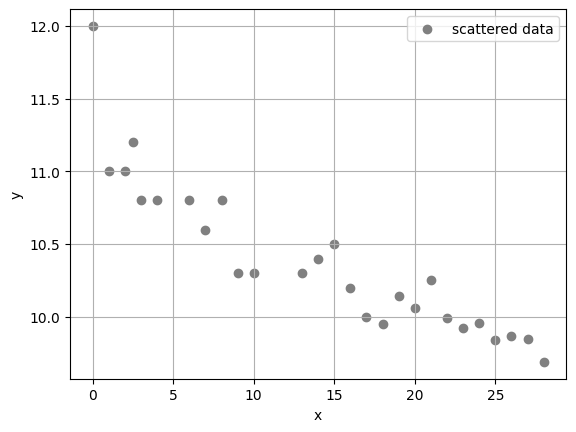

In [ ]:
plt.scatter(x, y, color = 'gray', label = 'scattered data')
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.legend()

In [ ]:
def w_mat(x,y):
  t = y
  X = np.vstack([np.ones_like(x),x]).T
  X_tX = np.matmul(X.T,X)
  invX_tX = np.linalg.inv(X_tX)
  X_t = np.matmul(X.T, t)
  w = np.matmul(invX_tX, X_t)
  return w

In [ ]:
x_test = np.linspace(min(x), max(x), 27)
w_test = w_mat(x,y)
print(w_test)
w_test.shape

[11.14109659 -0.05332354]


(2,)

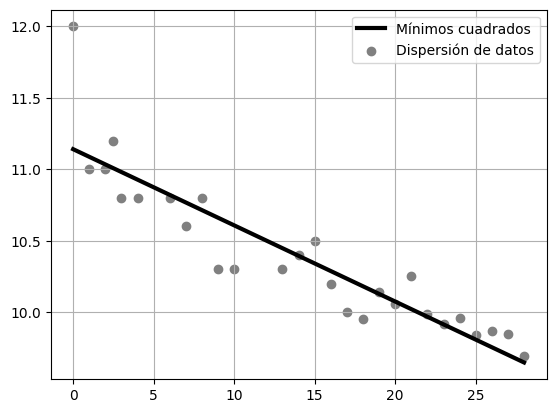

In [ ]:
x0 = np.linspace(min(x), max(x), 27)
y_p = w_test[0]+w_test[1]*x0
yerr =0.5 * np.random.rand(27)

plt.plot(x0, y_p, color = 'black', label = 'Mínimos cuadrados', linewidth = 3)
plt.scatter(x, y, color = 'gray', label = 'Dispersión de datos')
plt.grid()
plt.legend()
plt.show()

**EMCEE**

$ln(L) = -\frac{1}{2}\sum_{n}\left[\frac{(y_{n}-mx_{n}-b)^{2}}{s^{2}_{n}}+\ln{(2\pi s^{2}_{n})}\right]$

$s^{2}_{n}=\sigma^{2}_{n}+f^{2}(mx_{n}+b)^{2}$

In [ ]:
%%capture
!pip install -U setuptools setuptools_scm pep517
!pip install -U emcee
!python -m pip install corner

In [ ]:
N = 27
b_true = w_test[0]
m_true = w_test[1]
f_true = 0.534
yerr = 0.1 + 0.5 * np.random.rand(N)

In [ ]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

Maximum likelihood estimates:
m = -0.054
b = 11.140
f = 0.000


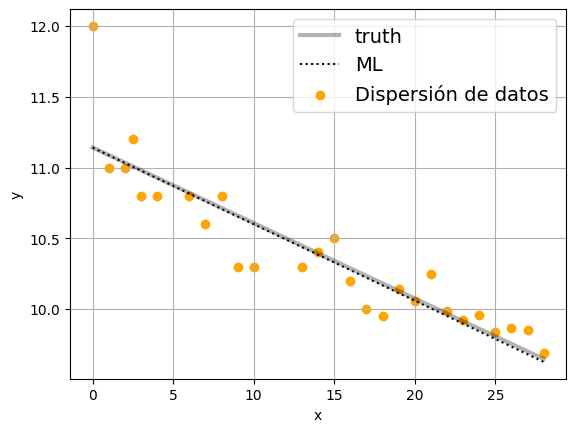

In [ ]:
from scipy.optimize import minimize

nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.scatter(x, y, color = 'orange', label = 'Dispersión de datos')
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y");
plt.grid()
plt.show()

In [ ]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

In [ ]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [ ]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:03<00:00, 1377.75it/s]


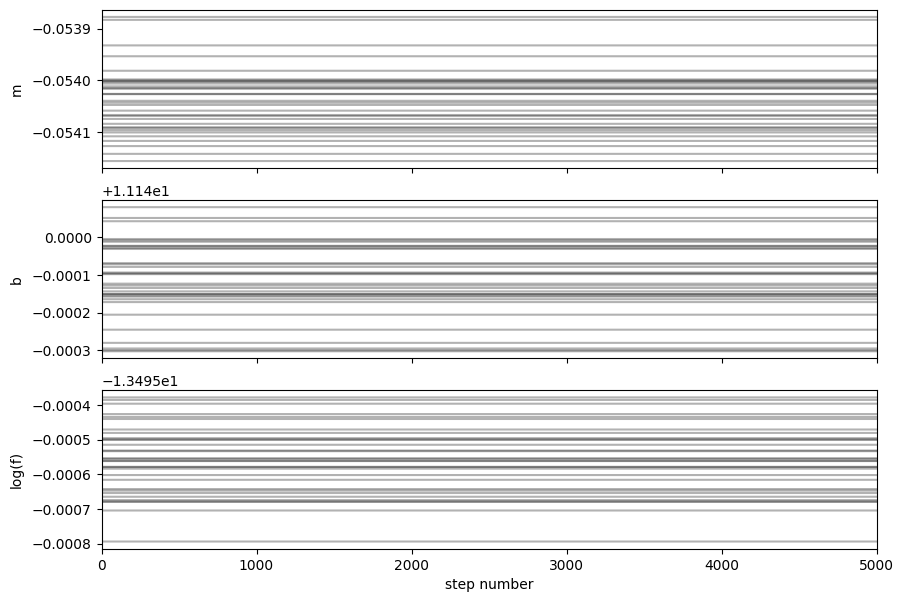

In [ ]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

[nan nan nan]


/usr/local/lib/python3.10/dist-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


In [ ]:
flat_samples = sampler.get_chain(discard=50, thin=15, flat=True)
print(flat_samples.shape)

(10560, 3)


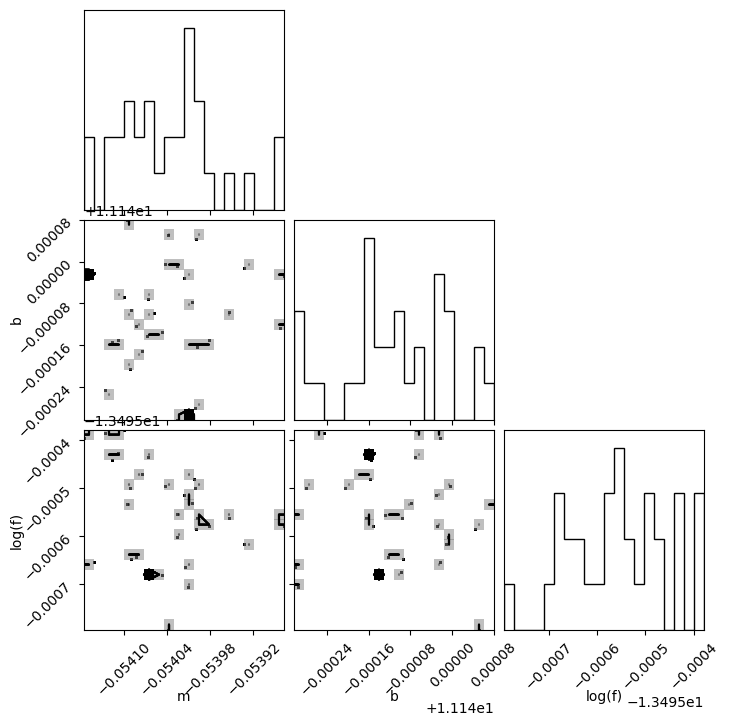

In [ ]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);

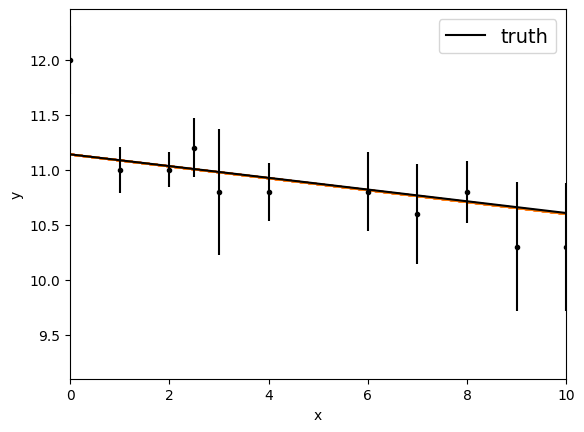

In [ ]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");